# Anime Recommendation System Project

## Imported Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
from random import randint

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
#from sklearn.preprocessing import MinMaxScalerort sklearn as skl

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import SVD
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise import Reader
from surprise import Dataset



## Datasets

#### Main Anime Dataset (anime.csv)

In [2]:
anime_main = pd.read_csv("data/anime.csv")

#### Anime Ratings Dataset (rating_complete.csv)

In [3]:
anime_ratings = pd.read_csv("data/rating_complete.csv")

In [4]:
print(anime_main.shape)
print(anime_main.columns.unique())
anime_main.head()

(17562, 35)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1'],
      dtype='object')


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [5]:
print(anime_ratings.shape)
print(anime_ratings.columns.unique())
anime_ratings.head()

(57633278, 3)
Index(['user_id', 'anime_id', 'rating'], dtype='object')


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


## Dataset Cleaning and Merging

In [6]:
# Clean main anime dataset and keep necessary features
anime_main = anime_main[['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes']]
anime_main.dropna(inplace=True)

print(anime_main.shape)
print(anime_main.columns)
anime_main.head()

(17562, 6)
Index(['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes'], dtype='object')


,MAL_ID,Name,Score,Genres,Type,Episodes
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,26
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",TV,26
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,52


In [7]:
# Rename columns and merge datasets
anime_main = anime_main.rename(columns={'MAL_ID': 'Anime ID'})
anime_ratings = anime_ratings.rename(columns={'user_id': 'User ID', 'anime_id': 'Anime ID', 'rating': 'Rating'})
anime_df = pd.merge(anime_main, anime_ratings, on='Anime ID')

In [8]:
print(anime_df.shape)
print(anime_df.columns)
anime_df.head()

(57633278, 8)
Index(['Anime ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes', 'User ID',
       'Rating'],
      dtype='object')


,Anime ID,Name,Score,Genres,Type,Episodes,User ID,Rating
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,3,9
1,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,6,6
2,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,14,9
3,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,19,8
4,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,22,9


In [9]:
anime_sample = anime_df.sample(n=1000)

## Data Visualizations

<AxesSubplot:xlabel='Type', ylabel='count'>

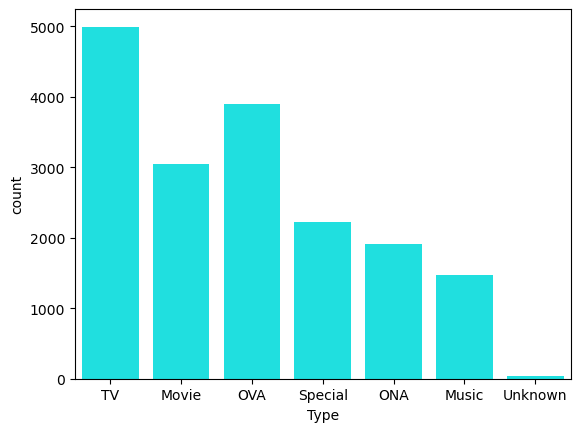

In [10]:
sns.countplot(x='Type', data=anime_main, color='cyan')

OVA = Original Video Animation, ONA = Original Net Animation

<AxesSubplot:xlabel='Rating', ylabel='count'>

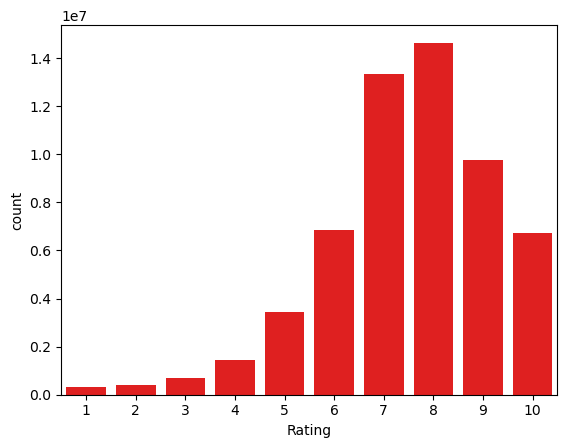

In [11]:
sns.countplot(x='Rating', data=anime_ratings, color='red')

In [12]:
# unique Genre values
genres = anime_main['Genres']
genres = pd.DataFrame([sub.split(",") for sub in genres])
pd.unique(genres.values.ravel('K'))

array(['Action', 'Adventure', 'Comedy', 'Slice of Life', 'Drama',
       'Sci-Fi', 'Samurai', 'Game', 'Harem', 'Military', 'Space', 'Music',
       'Mecha', 'Supernatural', 'Historical', 'Mystery', 'School',
       'Hentai', 'Fantasy', 'Ecchi', 'Horror', 'Kids', 'Sports',
       'Dementia', 'Magic', 'Romance', 'Police', 'Psychological', 'Cars',
       'Shounen', 'Demons', 'Parody', 'Shoujo', 'Super Power', 'Vampire',
       'Martial Arts', 'Seinen', 'Yaoi', 'Thriller', 'Josei', 'Unknown',
       'Shounen Ai', ' Adventure', ' Drama', ' Sci-Fi', ' Mystery',
       ' Fantasy', ' Sports', ' Comedy', ' Cars', ' Horror', ' Shounen',
       ' Romance', ' Supernatural', ' Military', ' Mecha', ' Dementia',
       ' Historical', ' Magic', ' Slice of Life', ' Demons', ' Harem',
       ' School', ' Ecchi', ' Psychological', ' Game', ' Super Power',
       ' Hentai', None, ' Parody', ' Music', ' Space', ' Shoujo',
       ' Josei', ' Seinen', ' Samurai', ' Martial Arts', ' Police',
       ' Kids', '

In [13]:
# # ALS model
# import implicit

# def create_data(datapath,start_date,end_date):
#     df = pd.read_csv(datapath)
#     df = df.assign(date = pd.Series(datetime.fromtimestamp(a/1000).date()
#                    for a in df.timestamp))
# model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

# Old SVD Code

In [14]:
# animeList = anime_main
# animeRatings = anime_ratings

In [15]:
# print(animeList.columns)
# print(animeRatings.columns)

In [16]:
# animeRatings = animeRatings.sample(n=5000)
# animeRatings.shape

In [17]:
# #Create Ratings Matrix
# ratings_mat = np.ndarray(
#     shape=(np.max(data.movie_id.values), np.max(data.user_id.values)),
#     dtype=np.uint8)
# ratings_mat[data.movie_id.values-1, data.user_id.values-1] = data.rating.values

#Create Ratings Matrix
#ratingsMat = np.ndarray(shape = (np.max(animeRatings['Anime ID'].values), np.max(animeRatings['User ID'].values)), dtype = np.uint8) 
#ratingsMat[animeRatings['Anime ID'].values-1, animeRatings['User ID'].values-1] = animeRatings['Rating'].values

In [18]:
#Normalize animeRating matrix
# normalized_Ratings = ratingsMat - np.asarray([(np.mean(ratingsMat, 1))]).T
# #Compute the SVD
# A = normalized_Ratings.T / np.sqrt(ratingsMat.shape[0] - 1)
# U, S, V = np.linalg.svd(A)

# #Define a function to calculate cosine similarity
# def topSimiliar(data, anime_id, top_n=10):
#     index = anime_id - 1 
#     anime_row = data[index, :]
#     magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
#     similarity = np.dot(anime_row, data.T) / (magnitude[index] * magnitude)
#     sort_Index = np.argsort(-similarity)
#     return sort_Index[:top_n]

In [19]:
# def printSimiliarAnime(animeList, animeID, numIndexes):
#     print('Recommendatinos for {0}:\n'.format
#         ( animeList[animeList.MAL_ID == animeID].Name.values[0] )
#     )
#     for iD in numIndexes + 1:
#         print(animeList[animeList.MAL_ID == animeID].name.values[0])

In [20]:
#Test
# k = 50
# animeID = 10
# numIndexes = 10
# sliced = V.T[:,:k]
# indexes = topSimiliar(sliced,animeID,numIndexes)

# printSimiliarAnime(animeList, animeID, indexes)

## New SVD Model

In [21]:
user_data = anime_sample[['User ID', 'Anime ID', 'Rating']]
reader = Reader(line_format = 'user item rating', sep='')
anime_data = Dataset.load_from_df(user_data,reader)

anime_trainset = anime_data.build_full_trainset()
anime_testset = anime_trainset.build_anti_testset()
#anime_train, anime_test = train_test_split(anime_data, test_size=.2)

In [22]:
anime_data

In [23]:
svd = SVD()
#svd.fit(anime_train)
svd.fit(anime_trainset)

In [24]:
#anime_predictions = svd.test(anime_test)
anime_predictions = svd.test(anime_testset)
accuracy.rmse(anime_predictions)

RMSE: 2.4100


2.4100000000000015

In [25]:
anime_predictions

[Prediction(uid=60043, iid=10490, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=22319, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=6547, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=10321, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=9981, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=18139, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=2964, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=5341, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=15315, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=31500, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=4491, r_ui=7.41, est=5, details={'was_impossible': False}),
 Prediction(uid=60043, iid=2016, r_ui

## Grid Search

In [26]:
# params = {'n_factors' : [30,60,90],
#           'reg_all': [.03,.05,.1]}
# gridsearch_svd = GridSearchCV(SVD, param_grid=params, n_jobs = -1, joblib_verbose = 3)
# gridsearch_svd.fit(anime_data)

# print(gridsearch_svd.best_score)
# print(gridsearch_svd.best_params)

In [27]:
from collections import defaultdict

def get_top_n(predictions, n = 10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [28]:
top_anime = get_top_n(anime_predictions,n=10)

for uid, user_ratings in top_anime.items():
    if len([iid for (iid, _) in user_ratings]) == 10:
        print(uid, [iid for (iid, _) in user_ratings])

60043 [10490, 22319, 6547, 10321, 9981, 18139, 2964, 5341, 15315, 31500]
107566 [32105, 22319, 6547, 10321, 9981, 18139, 2964, 5341, 15315, 31500]
241006 [32105, 10490, 6547, 10321, 9981, 18139, 2964, 5341, 15315, 31500]
173272 [32105, 10490, 22319, 10321, 9981, 18139, 2964, 5341, 15315, 31500]
313461 [32105, 10490, 22319, 6547, 9981, 18139, 2964, 5341, 15315, 31500]
5648 [32105, 10490, 22319, 6547, 10321, 18139, 2964, 5341, 15315, 31500]
212713 [32105, 10490, 22319, 6547, 10321, 9981, 2964, 5341, 15315, 31500]
222491 [32105, 10490, 22319, 6547, 10321, 9981, 18139, 5341, 15315, 31500]
75282 [32105, 10490, 22319, 6547, 10321, 9981, 18139, 2964, 15315, 31500]
309861 [32105, 10490, 22319, 6547, 10321, 9981, 18139, 2964, 5341, 31500]
305576 [32105, 10490, 22319, 6547, 10321, 9981, 18139, 2964, 5341, 15315]
349101 [32105, 10490, 22319, 6547, 10321, 9981, 18139, 2964, 5341, 15315]
343283 [32105, 10490, 22319, 6547, 10321, 9981, 18139, 2964, 5341, 15315]
249332 [32105, 10490, 22319, 6547, 103

In [29]:
user_id = -1
anime_ids = []
for uid, user_ratings in top_anime.items():
    if len([iid for (iid, _) in user_ratings]) == 10:
        user_id = uid
        anime_ids = [iid for (iid, _) in user_ratings]
        break
print(user_id, anime_ids)


60043 [10490, 22319, 6547, 10321, 9981, 18139, 2964, 5341, 15315, 31500]


In [30]:
for anime_id in anime_ids:
    row = anime_main[anime_main['Anime ID'] == anime_id]
    print(row['Name'])

6234    Blood-C
Name: Name, dtype: object
8646    Tokyo Ghoul
Name: Name, dtype: object
4636    Angel Beats!
Name: Name, dtype: object
6158    Uta no☆Prince-sama♪ Maji Love 1000%
Name: Name, dtype: object
6013    Phi Brain: Kami no Puzzle
Name: Name, dtype: object
7826    Tonari no Seki-kun
Name: Name, dtype: object
2706    Blue Drop: Tenshi-tachi no Gikyoku
Name: Name, dtype: object
4096    Ookami to Koushinryou II
Name: Name, dtype: object
7246    Mondaiji-tachi ga Isekai kara Kuru Sou Desu yo?
Name: Name, dtype: object
10973    High School Fleet
Name: Name, dtype: object


In [31]:
input_id = 353404
anime_ids = [10500, 37430, 16742, 356, 196]
input_ratings = [7.0, 8.0, 9.0, 7.0, 6.0]

num_inputs = 5

user_input_data = []
for i in range(num_inputs):
    user_input_data.append((input_id, anime_ids[i], input_ratings[i]))

In [32]:
# 
user_predictions = svd.test(user_input_data)
user_predictions

[Prediction(uid=353404, iid=10500, r_ui=7.0, est=5, details={'was_impossible': False}),
 Prediction(uid=353404, iid=37430, r_ui=8.0, est=5, details={'was_impossible': False}),
 Prediction(uid=353404, iid=16742, r_ui=9.0, est=5, details={'was_impossible': False}),
 Prediction(uid=353404, iid=356, r_ui=7.0, est=5, details={'was_impossible': False}),
 Prediction(uid=353404, iid=196, r_ui=6.0, est=5, details={'was_impossible': False})]

In [33]:
data = Dataset.load_builtin("ml-100k")
traindata = data.build_full_trainset()

print(traindata)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] 